# Instructions:

1. Set GOOGLE_COLAB to either True or False depending on if you are using Google Colab
2. Change the paths for the data files under the "ieee-fraud-detection" folder to whatever the actual paths are, if applicable
3. See what the values of all the constants should be. If you leave them at their defaults, that is also fine
4. Just run the entire file from start to finish each time you want to run it. It should work perfectly and skip over all the lengthy parts after the first complete run.
5. Save the code as a .tex along with all plots. Also, save the file as .ipynb.
6. Copy and paste "textCNN_submission.csv" to a separate folder for storage of Kaggle test data predictions. Hand this into Kaggle to get an accuracy score

# Imports

In [1]:
import csv
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
## RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
print(tf.__version__)

Using TensorFlow backend.


2.1.0


# Extra Code that must be run

In [2]:
GOOGLE_COLAB = False
if GOOGLE_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  # To unmount, terminate all sessions

In [3]:
def read(fileName):
    if GOOGLE_COLAB:
        file = open("gdrive/My Drive/Colab Notebooks/ieee-fraud-detection/" + fileName)
    else:
        file = open("ieee-fraud-detection/" + fileName)
    reader = csv.reader(file)
    print("Rows in " + fileName)
    print(len(list(reader)))

In [4]:
LESS_DATA_MODE = False
def selectRandomIndices(num_indices, num_to_keep, include_header = True):
    # NOTE: include_header = False for the "train" and "test" variables generated using pandas
    if include_header:
        indices = np.arange(1,num_indices+1,1)
    else:
        indices = np.arange(0,num_indices,1)
    
    if num_to_keep > len(indices):
        print("ERROR: Not enough indices to keep!")
        sys.exit()
    else:
        random.shuffle(indices)
        indices_to_use = indices[:num_to_keep]
        indices_to_use = np.sort(indices_to_use)
        indices_to_skip = indices[num_to_keep:]
        indices_to_skip = np.sort(indices_to_skip)
    
    if include_header and indices_to_use[0] != 0:
        indices_to_use = np.concatenate(([0],indices_to_use),axis=0)
    indices_to_skip = np.delete(indices_to_skip, 0, axis = None)
    
    return list(indices_to_use), list(indices_to_skip)


# Data info for entire dataset
NUM_TEST_DATA = 506691
NUM_TRAIN_DATA = 590540
NUM_INPUTS = 433
NUM_OUTPUTS = 1

It turns out that the number of rows corresponds to the number of rows in test_transaction.csv (test data) and train_transaction.csv (train data).

The number of columns in the train and test data correspond to:

    The number of columns in "train_transaction.csv" plus the number of columnns in "train_identity.csv"
    
    The number of columns in "test_transaction.csv" plus the number of columns in "train_identity.csv"

In [5]:
# Change the train and test data to contain a certain number of indices
NUM_TRAIN, NUM_TEST = 10000, 10000 # NUM_TEST >= 64 for this code to work
NUM_TRAIN, NUM_TEST = min(NUM_TRAIN,NUM_TRAIN_DATA), min(NUM_TEST,NUM_TEST_DATA)

if LESS_DATA_MODE:
    train_indices, train_indices_to_skip = selectRandomIndices(NUM_TRAIN_DATA, NUM_TRAIN, include_header = False) # include_header = False last time I checked
    test_indices, test_indices_to_skip = selectRandomIndices(NUM_TEST_DATA, NUM_TEST, include_header = False)
else:
    train_indices = list(np.arange(0,NUM_TRAIN_DATA,1))
    train_indices_to_skip = []
    test_indices = list(np.arange(0,NUM_TEST_DATA,1))
    test_indices_to_skip = []

In [6]:
# Recommended to be set to True
DEDICATED_TRAIN_AND_VAL = True

# CNN Code

In [7]:
#reading identity and transaction file of both train and test
    # NOTE: read(...) is just informative and gc.collect() is a type of "garbage collection" function or similar
if GOOGLE_COLAB:
    identity_train = pd.read_csv(r'gdrive/My Drive/Colab Notebooks/ieee-fraud-detection/train_identity.csv')
    if not LESS_DATA_MODE: read("train_identity.csv")
    train_transaction = pd.read_csv(r'gdrive/My Drive/Colab Notebooks/ieee-fraud-detection/train_transaction.csv',
                                    skiprows = train_indices_to_skip)
    if not LESS_DATA_MODE: read("train_transaction.csv")
else:
    identity_train = pd.read_csv(r'ieee-fraud-detection/train_identity.csv')
    if not LESS_DATA_MODE: read("train_identity.csv")
    train_transaction = pd.read_csv(r'ieee-fraud-detection/train_transaction.csv',
                                    skiprows = train_indices_to_skip)
    if not LESS_DATA_MODE: read("train_transaction.csv")

#Merging both the files on the basis of TransactionID column
train = pd.merge(train_transaction,identity_train, on='TransactionID', how='left',left_index=True,right_index=True)

#delete the individual files since we merge them into one
del train_transaction,identity_train
gc.collect()



if GOOGLE_COLAB:
    identity_test = pd.read_csv(r'gdrive/My Drive/Colab Notebooks/ieee-fraud-detection/test_identity.csv')
    if not LESS_DATA_MODE: read("test_identity.csv")
    test_transaction = pd.read_csv(r'gdrive/My Drive/Colab Notebooks/ieee-fraud-detection/test_transaction.csv',
                                    skiprows = test_indices_to_skip)
    if not LESS_DATA_MODE: read("test_transaction.csv")
else:
    identity_test = pd.read_csv(r'ieee-fraud-detection/test_identity.csv')
    if not LESS_DATA_MODE: read("test_identity.csv")
    test_transaction = pd.read_csv(r'ieee-fraud-detection/test_transaction.csv',
                                    skiprows = test_indices_to_skip)
    if not LESS_DATA_MODE: read("test_transaction.csv")

#Merging both the files on the basis of TransactionID column
test = pd.merge(test_transaction,identity_test, on='TransactionID', how='left',left_index=True,right_index=True)

#delete the individual files since we merge them into one
del test_transaction,identity_test
gc.collect()


test.head()

Rows in train_identity.csv
144234
Rows in train_transaction.csv
590541
Rows in test_identity.csv
141908
Rows in test_transaction.csv
506692


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


# **Feature extraction**

One of the important features in this dataset is `TransactionDT`. This is a time related feature and the time is in second.
From this feature we are creating 2 new features. Since this is in sec ,one feature will be in day and another feature will be in hour.

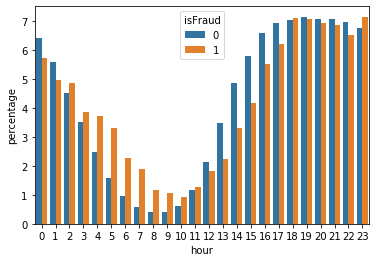

In [8]:
day_to_hour = (3600*24)-1
train['day'] = (train['TransactionDT']/day_to_hour)%7
train['hour'] = (train['TransactionDT']//(3600))%24
test['day'] = (test['TransactionDT']/day_to_hour)%7
test['hour'] = (test['TransactionDT']//(3600))%24

df = (train.groupby(['isFraud'])['hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hour'))
sns.barplot(x='hour', y='percentage', hue='isFraud', data=df)

Analyzing `TransactionAmt` feature


In [9]:
train_transAmt = train['TransactionAmt']
test_transAmt = test['TransactionAmt']

#Create a DataFrame
df = pd.DataFrame(train_transAmt)
print (df.describe(include='all'))

       TransactionAmt
count   590540.000000
mean       135.027176
std        239.162522
min          0.251000
25%         43.321000
50%         68.769000
75%        125.000000
max      31937.391000


In [10]:
df = pd.DataFrame(test_transAmt)
print (df.describe(include='all'))

       TransactionAmt
count   506691.000000
mean       134.725568
std        245.779822
min          0.018000
25%         40.000000
50%         67.950000
75%        125.000000
max      10270.000000


Upto 75%, values are below 125 but suddenly it rises to around 31937.391 in train and 10270 in test. Let's normalize the `TransactionAmt` feature.

In [11]:
train['LogTransactionAmt'] = np.log(train['TransactionAmt'])
test['LogTransactionAmt'] = np.log(test['TransactionAmt'])

In [12]:
if GOOGLE_COLAB:
    df_submission = pd.read_csv(r'gdrive/My Drive/Colab Notebooks/ieee-fraud-detection/sample_submission.csv',
                                skiprows = test_indices_to_skip)
else:
    df_submission = pd.read_csv(r'ieee-fraud-detection/sample_submission.csv',
                                skiprows = test_indices_to_skip)
if not LESS_DATA_MODE:
    read("sample_submission.csv")

Rows in sample_submission.csv
506692


In [13]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]


In [14]:
def intersection(lst1, lst2):
  return list(set(lst1) & set(lst2))
cols_to_drop_null = intersection(many_null_cols, many_null_cols_test)
cols_to_drop_btv = intersection(big_top_value_cols, big_top_value_cols_test)

cols_to_drop = list(set(cols_to_drop_null + cols_to_drop_btv))
cols_to_drop_train = []
cols_to_drop_test = []
for col in cols_to_drop:
    if col in train.columns:
        cols_to_drop_train.append(col)
#for col in cols_to_drop:
    if col in test.columns:
        cols_to_drop_test.append(col)

print(len(cols_to_drop_train))
print(len(cols_to_drop_test))

54
54


In [15]:
train = train.drop('TransactionAmt', axis=1)
test = test.drop('TransactionAmt', axis=1)
train = train.drop(cols_to_drop_train, axis=1)
test = test.drop(cols_to_drop_test, axis=1)

Treat the missing values. We will fill the missing value of the categorical value by mode and numerical value by mean.

In [16]:
#For numerical value imputation
for i in train.columns:
    if train[i].dtypes=='int64' or train[i].dtypes=='float64':
        train[i].fillna(train[i].mean(),inplace=True)

#For categorical value imputation
for i in train.columns:
    if train[i].dtypes=='object':
        train[i].fillna(train[i].mode()[0],inplace=True)

#For numerical value imputation
for i in test.columns:
    if test[i].dtypes=='int64' or test[i].dtypes=='float64':
        test[i].fillna(test[i].mean(),inplace=True)

#For categorical value imputation
for i in test.columns:
    if test[i].dtypes=='object':
        test[i].fillna(test[i].mode()[0],inplace=True)

Replace all the categorical values by unique numbers 

In [17]:
from sklearn.preprocessing import LabelEncoder
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

# This repetitive code is required to avoid an unknown bug for some unknown reason
cat_cols = ['id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29',
            'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in test.columns:
        le = LabelEncoder()
        le.fit(list(test[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

print(train.shape, test.shape)

(590540, 382) (506691, 381)


In [18]:
#Create independent and Dependent Features
columns1 = train.columns.tolist()
# Filter the columns to remove data we do not want 
columns1 = [c for c in columns1 if c not in ["isFraud"]]
# Store the variable we are predicting 
target = "isFraud"
# Define a random state 
state = np.random.RandomState() #42

X = train.sort_values('TransactionDT')
y = train.sort_values('TransactionDT')['isFraud']

In [19]:
X = X[columns1]
#y = y[target]
print(X.shape)
print(y.shape)

(590540, 381)
(590540,)


In [20]:
OVERSAMPLING = True
if OVERSAMPLING:
    os = RandomOverSampler()
    X_res,y_res=os.fit_sample(X,y)
else:
    X_res = X
    y_res = y

In [21]:
#split into train and validation data
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_res, y_res, test_size = 0.2, random_state = 0, stratify = y_res)
print(X_train.shape, X_val.shape)

# If oversampling works, these should both print 0.5
print(np.average(Y_train))
print(np.average(Y_val))

(911803, 381) (227951, 381)
0.5000005483640655
0.4999978065461437


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#for dedicated train and validation set 
X_train = scaler.fit_transform(X_train) 
X_val = scaler.transform(X_val)

#for multiplpe fold validation
X_res = scaler.fit_transform(X_res)
X_res = scaler.transform(X_res)


In [23]:
test = scaler.fit_transform(test)
test = scaler.transform(test)
test = test.reshape(test.shape[0], test.shape[1], 1)

In [24]:
#for dedicated train and validation set 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
print(X_train.shape, X_val.shape)

#for multiplpe fold validation
X_res = X_res.reshape(X_res.shape[0], X_res.shape[1], 1)
print(X_res.shape)

(911803, 381, 1) (227951, 381, 1)
(1139754, 381, 1)


In [25]:
def create_model():
    epochs = 1
    model = Sequential()
    model.add(Conv1D(20, 2, activation='relu', input_shape = X_res[0].shape))
    #model.add(Dense(20, activation='relu', input_shape = X_res[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))
    model.add(Dropout(0.2))

    model.add(Conv1D(20, 2, activation='relu'))
    #model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))
    model.add(Dropout(0.5))
    
    model.add(Flatten()) # Required for model to work properly
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=SGD(), loss = 'binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
num_epochs = 5
history = []
checkpoint_path = "cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True, monitor='val_accuracy',save_weights_only=True, verbose=1, mode='max')
li = list(np.arange(0,X_res.shape[1],1))

model_ckpt= create_model()
if DEDICATED_TRAIN_AND_VAL:
    hist = model_ckpt.fit(X_train, Y_train, batch_size=64, epochs=1, verbose=1, validation_split=0.0, validation_data=(X_val, Y_val),callbacks=[cp_callback]) #shuffle=True
else:
    hist = model_ckpt.fit(X_res, y_res, batch_size=64, epochs=1,  verbose=1, validation_split=0.2, callbacks=[cp_callback]) #shuffle=True

print(hist)
history.append(hist)

for epoch in range(num_epochs):
    model_ckpt1 = create_model()
    model_ckpt1.load_weights(checkpoint_path)
    if DEDICATED_TRAIN_AND_VAL:
        hist = model_ckpt.fit(X_train, Y_train, batch_size=64, epochs=1, verbose=1, validation_split=0.0, validation_data=(X_val, Y_val),callbacks=[cp_callback]) #shuffle=True
    else:
        hist = model_ckpt1.fit(X_res, y_res, batch_size=64, epochs=1,  verbose=1, validation_split=0.2, callbacks=[cp_callback])   #shuffle=True
    history.append(hist)

Train on 911803 samples, validate on 227951 samples
911680/911803 [============================>.] - ETA: 0s - loss: 0.5293 - accuracy: 0.7293
Epoch 00001: val_accuracy improved from -inf to 0.77199, saving model to cp.ckpt
911803/911803 [==============================] - 292s 321us/sample - loss: 0.5293 - accuracy: 0.7293 - val_loss: 0.4751 - val_accuracy: 0.7720
Train on 911803 samples, validate on 227951 samples
911616/911803 [============================>.] - ETA: 0s - loss: 0.5001 - accuracy: 0.7511
Epoch 00001: val_accuracy improved from 0.77199 to 0.77690, saving model to cp.ckpt
911803/911803 [==============================] - 292s 320us/sample - loss: 0.5002 - accuracy: 0.7511 - val_loss: 0.4604 - val_accuracy: 0.7769
Train on 911803 samples, validate on 227951 samples
911744/911803 [============================>.] - ETA: 0s - loss: 0.4918 - accuracy: 0.7571
Epoch 00001: val_accuracy improved from 0.77690 to 0.78296, saving model to cp.ckpt
911803/911803 [=====================

In [27]:
# saving the model
model_json = model_ckpt1.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
model_ckpt1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 380, 20)           60        
_________________________________________________________________
batch_normalization_10 (Batc (None, 380, 20)           80        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 190, 20)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 190, 20)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 189, 20)           820       
_________________________________________________________________
batch_normalization_11 (Batc (None, 189, 20)           80        
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 94, 20)           

In [28]:
# testing and getting predictions
predicted_labels = model_ckpt1.predict(test, batch_size=64, verbose=1)
predicted_labels = np.round(predicted_labels,3)
print(np.average(predicted_labels))

# Submit "textCNN_submission.csv" to Kaggle
df_submission["isFraud"] = predicted_labels
df_submission.to_csv('textCNN_submission.csv', index=False)

506691/506691 [==============================] - 25s 49us/sample
0.98351806


In [29]:
accuracy = []
val_accuracy = []
loss = []
val_loss = []
for i in range(len(history)):
    accuracy.append(history[i].history['accuracy'])
    val_accuracy.append(history[i].history['val_accuracy'])
    loss.append(history[i].history['loss'])
    val_loss.append(history[i].history['val_loss'])

In [30]:
import matplotlib
def plot_learningCurve(epoch, accuracy, val_accuracy, loss, val_loss):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, accuracy)
  plt.plot(epoch_range, val_accuracy)
  plt.title('Model accuracy', fontsize=24)
  plt.ylabel('Accuracy', fontsize=16)
  plt.xlabel('Epoch', fontsize=16)
  plt.legend(['Train', 'Val'], loc='lower right', fontsize=14)
  matplotlib.rcParams.update({'font.size': 12})
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, loss)
  plt.plot(epoch_range, val_loss)
  plt.title('Model loss', fontsize=24)
  plt.ylabel('Loss', fontsize=16)
  plt.xlabel('Epoch', fontsize=16)
  plt.legend(['Train', 'Val'], loc='upper right', fontsize=14)
  matplotlib.rcParams.update({'font.size': 12})
  plt.show()

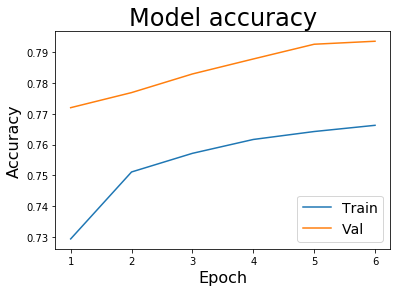

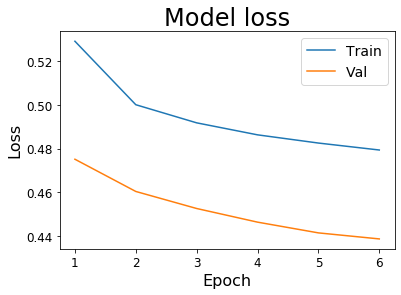

In [31]:
plot_learningCurve(num_epochs+1, accuracy, val_accuracy, loss, val_loss)

0.8728098106275992


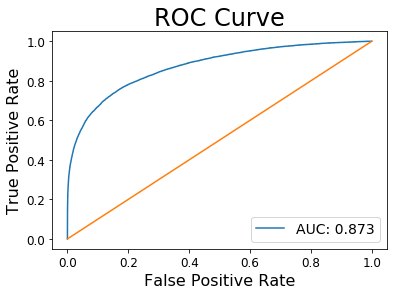

In [32]:
import sklearn

if DEDICATED_TRAIN_AND_VAL:
    X_plot = X_val
    Y_plot = Y_val
else:
    X_plot = X_res
    Y_plot = y_res

# Evaluate ROC curve based on validation data
Y_pred = model_ckpt1.predict(X_plot)
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_plot, Y_pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)
print(roc_auc)

# Plot ROC-AUC curve
plt.plot(fpr, tpr, [0,1], [0,1])
plt.title('ROC Curve', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.legend(['AUC: %0.3f' % roc_auc],loc='lower right', fontsize=14)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

In [33]:
if DEDICATED_TRAIN_AND_VAL:
    print(X_train.shape)
    print(Y_train.shape)
    print(X_val.shape)
    print(Y_val.shape)
else:
    print(X_res.shape)
    print(y_res.shape)


(911803, 381, 1)
(911803,)
(227951, 381, 1)
(227951,)
